In [34]:
!pip install imbalanced-learn

In [35]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


In [36]:
np.random.seed(42)

sample_sizes = {
    "Control": 2161,
    "Malignant": 1201,
    "Benign": 792,
    "Indeterminate": 209
}

distributions = {
    "Age": {
        "<35": [0.205, 0.097, 0.419, 0.273],
        "35-44": [0.269, 0.245, 0.268, 0.244],
        "45-54": [0.261, 0.300, 0.187, 0.230],
        "≥55": [0.261, 0.356, 0.124, 0.254],
        "Unknown": [0.005, 0.003, 0.003, 0.0],
    },
    "Education": {
        "No formal education": [0.239, 0.227, 0.122, 0.124],
        "Primary school": [0.174, 0.137, 0.078, 0.110],
        "Junior secondary school": [0.307, 0.235, 0.237, 0.263],
        "≥ Senior secondary school": [0.246, 0.333, 0.529, 0.440],
        "Unknown": [0.034, 0.067, 0.033, 0.062],
    },
    "Family_History": {
        "No": [0.967, 0.918, 0.912, 0.914],
        "Yes": [0.022, 0.070, 0.074, 0.077],
        "Unknown": [0.011, 0.012, 0.014, 0.010],
    },
    "Parity": {
        "Nulliparous": [0.107, 0.092, 0.303, 0.234],
        "1-2": [0.261, 0.285, 0.306, 0.292],
        "3-4": [0.323, 0.326, 0.246, 0.268],
        "≥5": [0.304, 0.292, 0.143, 0.201],
        "Unknown": [0.004, 0.004, 0.003, 0.005],
    },
    "Menarche_Age": {
        "<15": [0.279, 0.238, 0.383, 0.321],
        "15": [0.257, 0.224, 0.240, 0.211],
        "16": [0.180, 0.197, 0.169, 0.167],
        "≥17": [0.185, 0.206, 0.138, 0.182],
        "Unknown": [0.099, 0.134, 0.071, 0.120],
    },
    "Menopause_Age": {
        "Premenopausal": [0.576, 0.422, 0.758, 0.617],
        "<45": [0.079, 0.114, 0.068, 0.086],
        "45-49": [0.124, 0.164, 0.068, 0.091],
        "50-54": [0.137, 0.182, 0.072, 0.129],
        "≥55": [0.032, 0.051, 0.010, 0.014],
        "Unknown": [0.052, 0.067, 0.024, 0.062],
    },
    "Body_Size": {
        "Slight": [0.273, 0.227, 0.360, 0.282],
        "Average": [0.398, 0.382, 0.386, 0.392],
        "Slightly heavy": [0.225, 0.228, 0.174, 0.187],
        "Very heavy": [0.076, 0.093, 0.045, 0.062],
        "Unknown": [0.028, 0.069, 0.034, 0.077],
    }
}

# Fixed sampling function — normalize probabilities
def sample_feature(feature_dict, group_index, n):
    categories = list(feature_dict.keys())
    probs = np.array([v[group_index] for v in feature_dict.values()])
    probs = probs / probs.sum()  # normalize to sum=1
    return np.random.choice(categories, size=n, p=probs)

# Generate simulated dataset
dataframes = []

for i, group in enumerate(sample_sizes.keys()):
    n = sample_sizes[group]
    df = pd.DataFrame({
        "Diagnosis_Type": group,
        "Age": sample_feature(distributions["Age"], i, n),
        "Education": sample_feature(distributions["Education"], i, n),
        "Family_History": sample_feature(distributions["Family_History"], i, n),
        "Parity": sample_feature(distributions["Parity"], i, n),
        "Menarche_Age": sample_feature(distributions["Menarche_Age"], i, n),
        "Menopause_Age": sample_feature(distributions["Menopause_Age"], i, n),
        "Body_Size": sample_feature(distributions["Body_Size"], i, n)
    })
    dataframes.append(df)

df_all = pd.concat(dataframes, ignore_index=True)
df_all["Target"] = df_all["Diagnosis_Type"].map({"Control": 0,
                                                  "Benign": 0,
                                                 "Indeterminate": 0,
                                                 "Malignant": 1})

df_all.to_csv("breast_cancer.csv", index=False)


In [37]:
df = pd.read_csv("breast_cancer.csv")

In [38]:
df['Target'].value_counts()

,count
Target,
0,3162
1,1201


In [39]:
df.sample(10)

,Diagnosis_Type,Age,Education,Family_History,Parity,Menarche_Age,Menopause_Age,Body_Size,Target
2883,Malignant,45-54,Junior secondary school,No,3-4,<15,50-54,Average,1
1980,Control,<35,No formal education,No,≥5,Unknown,50-54,Slight,0
999,Control,35-44,Junior secondary school,No,3-4,<15,Unknown,Slightly heavy,0
2465,Malignant,≥55,Junior secondary school,No,1-2,<15,45-49,Slight,1
3658,Benign,35-44,Junior secondary school,No,3-4,<15,Premenopausal,Slightly heavy,0
1059,Control,45-54,Junior secondary school,No,3-4,≥17,50-54,Average,0
3515,Benign,35-44,Junior secondary school,No,≥5,<15,Premenopausal,Average,0
898,Control,<35,≥ Senior secondary school,No,1-2,15,Premenopausal,Slightly heavy,0
1096,Control,35-44,No formal education,No,≥5,<15,Unknown,Average,0
295,Control,45-54,Junior secondary school,No,≥5,15,Premenopausal,Average,0


In [40]:
print(df_all.columns)

Index(['Diagnosis_Type', 'Age', 'Education', 'Family_History', 'Parity',
       'Menarche_Age', 'Menopause_Age', 'Body_Size', 'Target'],
      dtype='object')


In [41]:
df["Parity"].unique()

array(['Nulliparous', '1-2', '3-4', '≥5', 'Unknown'], dtype=object)

In [42]:
df['Parity'] = df['Parity'].map(lambda x: 0 if x == 'Nulliparous' else x)

In [43]:
df.shape

(4363, 9)

In [44]:
df.rename(columns={
    'Menarche_Age': 'Age_at_Menarche',
    'Menopause_Age': 'Age_at_Menopause'
}, inplace=True)


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4363 entries, 0 to 4362
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Diagnosis_Type    4363 non-null   object
 1   Age               4363 non-null   object
 2   Education         4363 non-null   object
 3   Family_History    4363 non-null   object
 4   Parity            4363 non-null   object
 5   Age_at_Menarche   4363 non-null   object
 6   Age_at_Menopause  4363 non-null   object
 7   Body_Size         4363 non-null   object
 8   Target            4363 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 306.9+ KB


In [46]:
df['Age_at_Menarche'].unique()

array(['16', '15', '<15', '≥17', 'Unknown'], dtype=object)

In [47]:
df['Age_at_Menopause'].unique()

array(['Premenopausal', '45-49', '<45', '50-54', 'Unknown', '≥55'],
      dtype=object)

In [48]:
df['Family_History'].unique()

array(['No', 'Yes', 'Unknown'], dtype=object)

In [49]:
df.dtypes

,0
Diagnosis_Type,object
Age,object
Education,object
Family_History,object
Parity,object
Age_at_Menarche,object
Age_at_Menopause,object
Body_Size,object
Target,int64


In [50]:
df.drop('Diagnosis_Type', axis=1, inplace=True)

In [51]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


Age: 5 unique values
Education: 5 unique values
Family_History: 3 unique values
Parity: 5 unique values
Age_at_Menarche: 5 unique values
Age_at_Menopause: 6 unique values
Body_Size: 5 unique values
Target: 2 unique values


In [52]:
warnings.filterwarnings("ignore")

categorical_features = [
    "Age",
    "Education",
    "Family_History",
    "Parity",
    "Age_at_Menarche",
    "Age_at_Menopause",
    "Body_Size"
]

results = []

# --- Chi-Square & Cramer's V for each feature ---
for col in categorical_features:
    # Create contingency table
    contingency_table = pd.crosstab(df[col], df['Target'])

    # Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Compute Cramer's V
    n = contingency_table.sum().sum()
    k = contingency_table.shape[1]
    r = contingency_table.shape[0]
    cramers_v = np.sqrt((chi2 / n) / min(k - 1, r - 1))

    # Store results
    results.append({
        "Feature": col,
        "Chi2": chi2,
        "p_value": p,
        "Cramers_V": cramers_v
    })

# --- Convert to DataFrame ---
chi_results = pd.DataFrame(results)

# --- Sort by strength of relationship ---
chi_results = chi_results.sort_values("Cramers_V", ascending=False).reset_index(drop=True)

print("\n=== Chi-Square & Cramer's V Results ===")
print(chi_results)


=== Chi-Square & Cramer's V Results ===
            Feature        Chi2       p_value  Cramers_V
0  Age_at_Menopause  180.217682  4.807860e-37   0.203239
1               Age  178.127202  1.882430e-37   0.202056
2         Body_Size   84.975693  1.535079e-17   0.139558
3   Age_at_Menarche   61.554662  1.366760e-12   0.118779
4            Parity   50.619174  2.681020e-10   0.107712
5         Education   30.222637  4.409293e-06   0.083229
6    Family_History   21.312659  2.355130e-05   0.069892


In [53]:
df['Target'].value_counts(normalize=True) * 100

,proportion
Target,
0,72.473069
1,27.526931


In [54]:
X = df[categorical_features]
y = df["Target"]

X = X.astype(str)  # convert all to string

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify ensures same class ratio in both sets
)

**MODEL TRAINING**

In [55]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [56]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=2000,
        solver='liblinear',
        C=1.0,
        class_weight='balanced',
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=8,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.01,
        max_depth=4,
        subsample=0.8,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=42
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='minkowski'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,  # or adjust for imbalance
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

In [57]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__solver': ['lbfgs', 'liblinear']
    },
    'Decision Tree': {
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.2],
        'model__max_depth': [3, 5]
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}



Training Random Forest on 1 with smote val 0.8...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[[463 170]
 [106 134]]


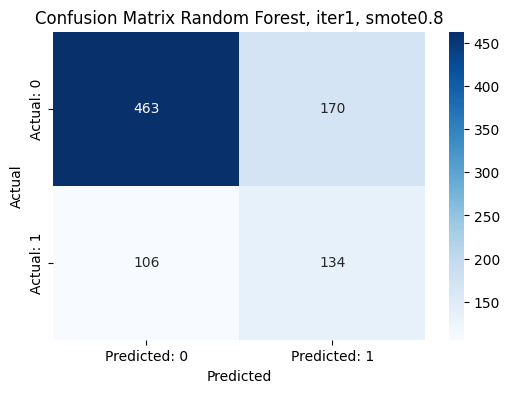

Random Forest iter1 with smote val0.8 Accuracy: 0.6838
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       633
           1       0.44      0.56      0.49       240

    accuracy                           0.68       873
   macro avg       0.63      0.64      0.63       873
weighted avg       0.71      0.68      0.69       873

Saved Random Forest pipeline as: random_forest_iter1_smote0.8_pipeline.pkl

Training Logistic Regression on 1 with smote val 0.8...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[395 238]
 [ 66 174]]


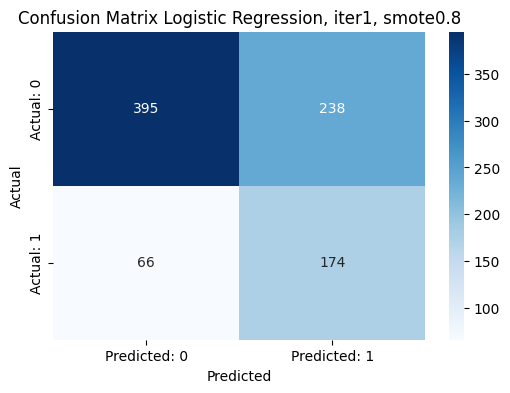

Logistic Regression iter1 with smote val0.8 Accuracy: 0.6518
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       633
           1       0.42      0.72      0.53       240

    accuracy                           0.65       873
   macro avg       0.64      0.67      0.63       873
weighted avg       0.74      0.65      0.67       873

Saved Logistic Regression pipeline as: logistic_regression_iter1_smote0.8_pipeline.pkl

Training Decision Tree on 1 with smote val 0.8...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[[454 179]
 [126 114]]


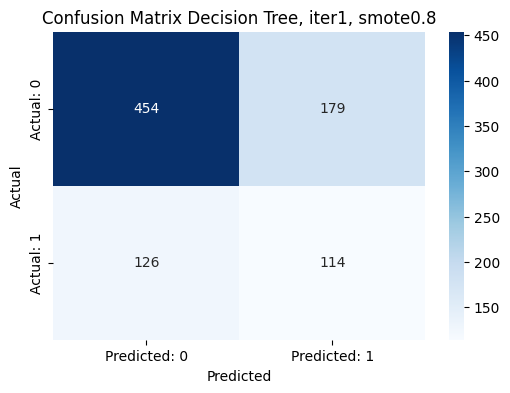

Decision Tree iter1 with smote val0.8 Accuracy: 0.6506
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       633
           1       0.39      0.47      0.43       240

    accuracy                           0.65       873
   macro avg       0.59      0.60      0.59       873
weighted avg       0.67      0.65      0.66       873

Saved Decision Tree pipeline as: decision_tree_iter1_smote0.8_pipeline.pkl

Training Gradient Boosting on 1 with smote val 0.8...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[[514 119]
 [131 109]]


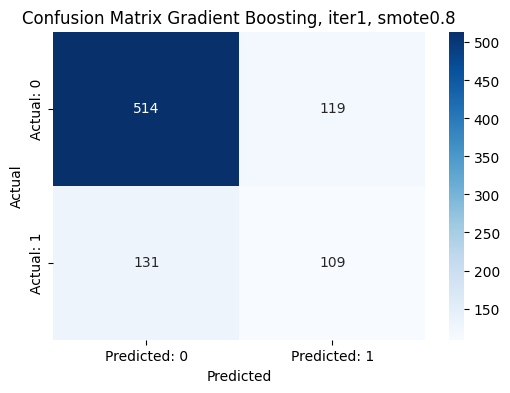

Gradient Boosting iter1 with smote val0.8 Accuracy: 0.7136
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       633
           1       0.48      0.45      0.47       240

    accuracy                           0.71       873
   macro avg       0.64      0.63      0.64       873
weighted avg       0.71      0.71      0.71       873

Saved Gradient Boosting pipeline as: gradient_boosting_iter1_smote0.8_pipeline.pkl

Training SVM on 1 with smote val 0.8...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[384 249]
 [ 66 174]]


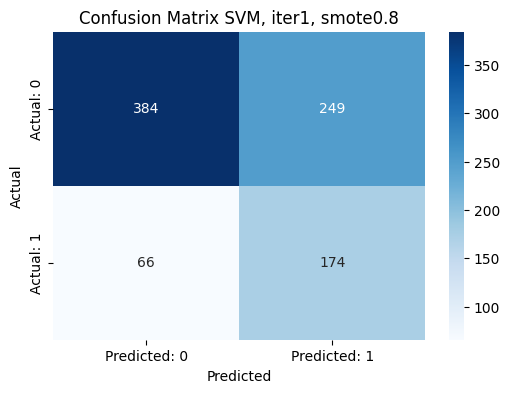

SVM iter1 with smote val0.8 Accuracy: 0.6392
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       633
           1       0.41      0.72      0.52       240

    accuracy                           0.64       873
   macro avg       0.63      0.67      0.62       873
weighted avg       0.73      0.64      0.66       873

Saved SVM pipeline as: svm_iter1_smote0.8_pipeline.pkl

Training KNN on 1 with smote val 0.8...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[434 199]
 [112 128]]


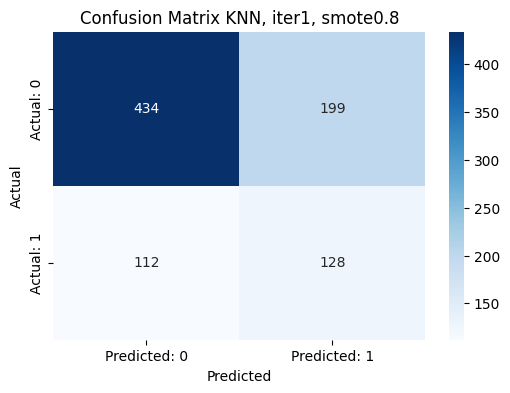

KNN iter1 with smote val0.8 Accuracy: 0.6438
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       633
           1       0.39      0.53      0.45       240

    accuracy                           0.64       873
   macro avg       0.59      0.61      0.59       873
weighted avg       0.68      0.64      0.66       873

Saved KNN pipeline as: knn_iter1_smote0.8_pipeline.pkl

Training XGBoost on 1 with smote val 0.8...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[594  39]
 [197  43]]


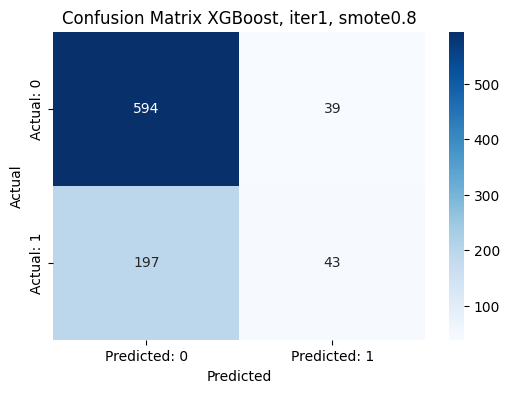

XGBoost iter1 with smote val0.8 Accuracy: 0.7297
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       633
           1       0.52      0.18      0.27       240

    accuracy                           0.73       873
   macro avg       0.64      0.56      0.55       873
weighted avg       0.69      0.73      0.68       873

Saved XGBoost pipeline as: xgboost_iter1_smote0.8_pipeline.pkl

Training Random Forest on 1 with smote val 1.1...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[[470 163]
 [107 133]]


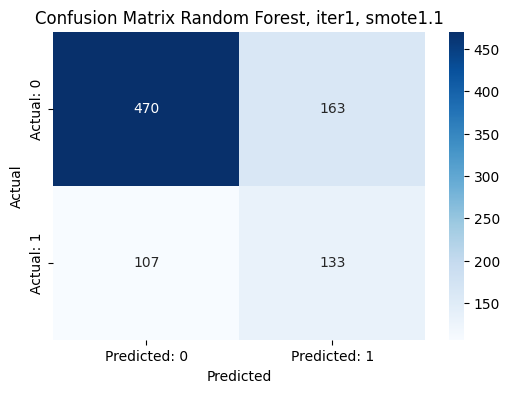

Random Forest iter1 with smote val1.1 Accuracy: 0.6907
              precision    recall  f1-score   support

           0       0.81      0.74      0.78       633
           1       0.45      0.55      0.50       240

    accuracy                           0.69       873
   macro avg       0.63      0.65      0.64       873
weighted avg       0.71      0.69      0.70       873

Saved Random Forest pipeline as: random_forest_iter1_smote1.1_pipeline.pkl

Training Logistic Regression on 1 with smote val 1.1...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[395 238]
 [ 71 169]]


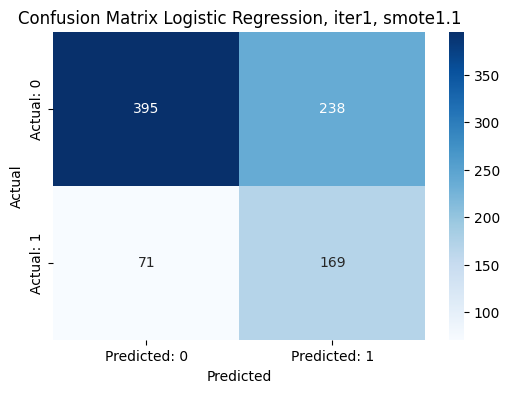

Logistic Regression iter1 with smote val1.1 Accuracy: 0.6460
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       633
           1       0.42      0.70      0.52       240

    accuracy                           0.65       873
   macro avg       0.63      0.66      0.62       873
weighted avg       0.73      0.65      0.66       873

Saved Logistic Regression pipeline as: logistic_regression_iter1_smote1.1_pipeline.pkl

Training Decision Tree on 1 with smote val 1.1...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[[474 159]
 [115 125]]


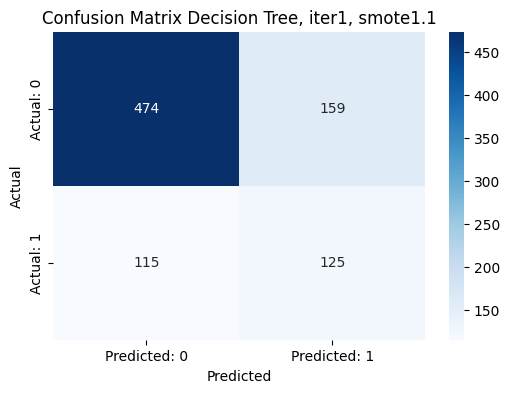

Decision Tree iter1 with smote val1.1 Accuracy: 0.6861
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       633
           1       0.44      0.52      0.48       240

    accuracy                           0.69       873
   macro avg       0.62      0.63      0.63       873
weighted avg       0.70      0.69      0.69       873

Saved Decision Tree pipeline as: decision_tree_iter1_smote1.1_pipeline.pkl

Training Gradient Boosting on 1 with smote val 1.1...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[[442 191]
 [ 90 150]]


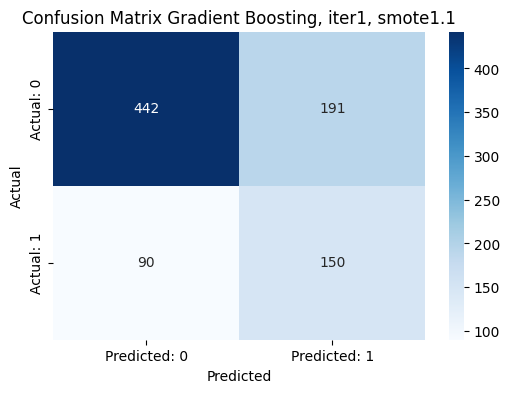

Gradient Boosting iter1 with smote val1.1 Accuracy: 0.6781
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       633
           1       0.44      0.62      0.52       240

    accuracy                           0.68       873
   macro avg       0.64      0.66      0.64       873
weighted avg       0.72      0.68      0.69       873

Saved Gradient Boosting pipeline as: gradient_boosting_iter1_smote1.1_pipeline.pkl

Training SVM on 1 with smote val 1.1...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[379 254]
 [ 67 173]]


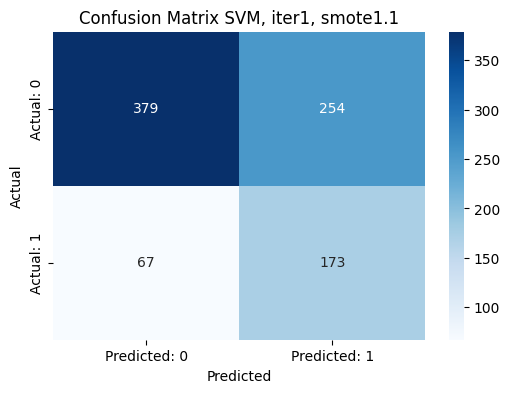

SVM iter1 with smote val1.1 Accuracy: 0.6323
              precision    recall  f1-score   support

           0       0.85      0.60      0.70       633
           1       0.41      0.72      0.52       240

    accuracy                           0.63       873
   macro avg       0.63      0.66      0.61       873
weighted avg       0.73      0.63      0.65       873

Saved SVM pipeline as: svm_iter1_smote1.1_pipeline.pkl

Training KNN on 1 with smote val 1.1...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[387 246]
 [ 98 142]]


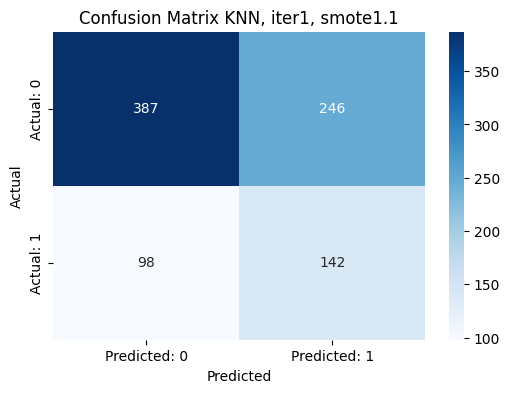

KNN iter1 with smote val1.1 Accuracy: 0.6060
              precision    recall  f1-score   support

           0       0.80      0.61      0.69       633
           1       0.37      0.59      0.45       240

    accuracy                           0.61       873
   macro avg       0.58      0.60      0.57       873
weighted avg       0.68      0.61      0.63       873

Saved KNN pipeline as: knn_iter1_smote1.1_pipeline.pkl

Training XGBoost on 1 with smote val 1.1...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[502 131]
 [123 117]]


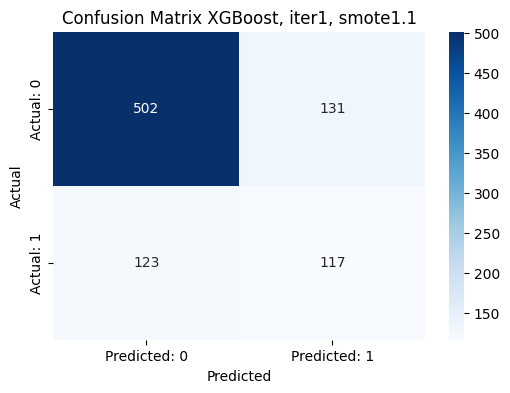

XGBoost iter1 with smote val1.1 Accuracy: 0.7090
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       633
           1       0.47      0.49      0.48       240

    accuracy                           0.71       873
   macro avg       0.64      0.64      0.64       873
weighted avg       0.71      0.71      0.71       873

Saved XGBoost pipeline as: xgboost_iter1_smote1.1_pipeline.pkl

Training Random Forest on 1 with smote val 1.5...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[[483 150]
 [116 124]]


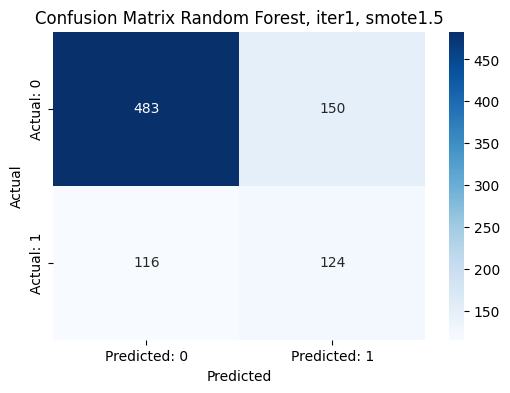

Random Forest iter1 with smote val1.5 Accuracy: 0.6953
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       633
           1       0.45      0.52      0.48       240

    accuracy                           0.70       873
   macro avg       0.63      0.64      0.63       873
weighted avg       0.71      0.70      0.70       873

Saved Random Forest pipeline as: random_forest_iter1_smote1.5_pipeline.pkl

Training Logistic Regression on 1 with smote val 1.5...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[400 233]
 [ 69 171]]


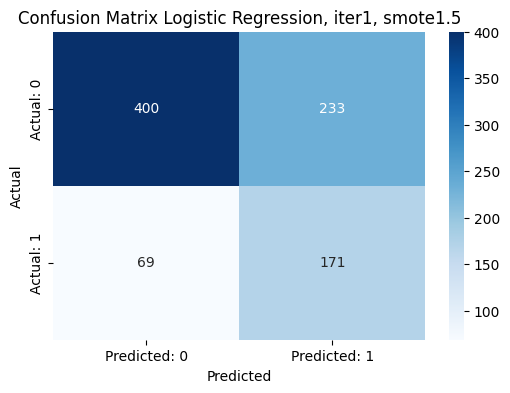

Logistic Regression iter1 with smote val1.5 Accuracy: 0.6541
              precision    recall  f1-score   support

           0       0.85      0.63      0.73       633
           1       0.42      0.71      0.53       240

    accuracy                           0.65       873
   macro avg       0.64      0.67      0.63       873
weighted avg       0.73      0.65      0.67       873

Saved Logistic Regression pipeline as: logistic_regression_iter1_smote1.5_pipeline.pkl

Training Decision Tree on 1 with smote val 1.5...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[[493 140]
 [127 113]]


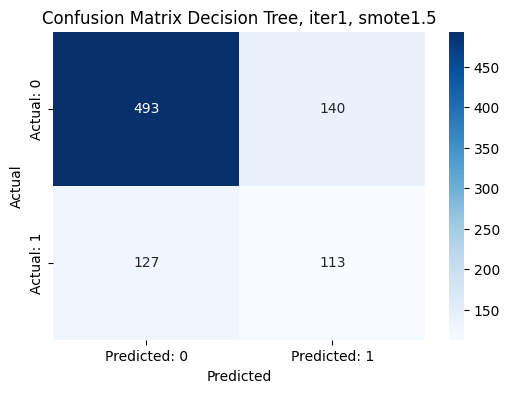

Decision Tree iter1 with smote val1.5 Accuracy: 0.6942
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       633
           1       0.45      0.47      0.46       240

    accuracy                           0.69       873
   macro avg       0.62      0.62      0.62       873
weighted avg       0.70      0.69      0.70       873

Saved Decision Tree pipeline as: decision_tree_iter1_smote1.5_pipeline.pkl

Training Gradient Boosting on 1 with smote val 1.5...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[[350 283]
 [ 62 178]]


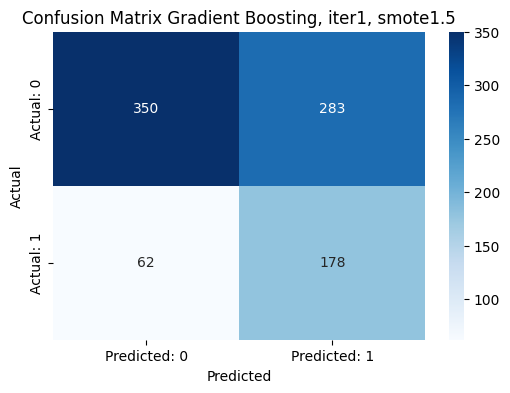

Gradient Boosting iter1 with smote val1.5 Accuracy: 0.6048
              precision    recall  f1-score   support

           0       0.85      0.55      0.67       633
           1       0.39      0.74      0.51       240

    accuracy                           0.60       873
   macro avg       0.62      0.65      0.59       873
weighted avg       0.72      0.60      0.63       873

Saved Gradient Boosting pipeline as: gradient_boosting_iter1_smote1.5_pipeline.pkl

Training SVM on 1 with smote val 1.5...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[384 249]
 [ 69 171]]


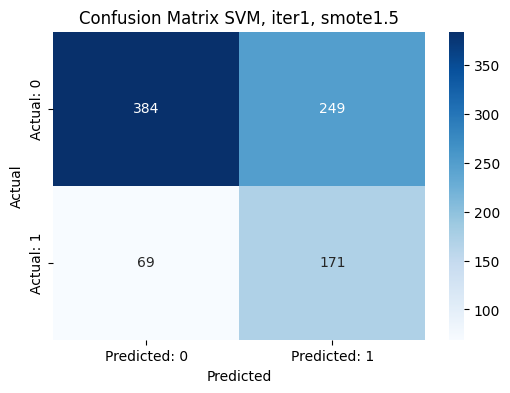

SVM iter1 with smote val1.5 Accuracy: 0.6357
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       633
           1       0.41      0.71      0.52       240

    accuracy                           0.64       873
   macro avg       0.63      0.66      0.61       873
weighted avg       0.73      0.64      0.66       873

Saved SVM pipeline as: svm_iter1_smote1.5_pipeline.pkl

Training KNN on 1 with smote val 1.5...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[338 295]
 [ 83 157]]


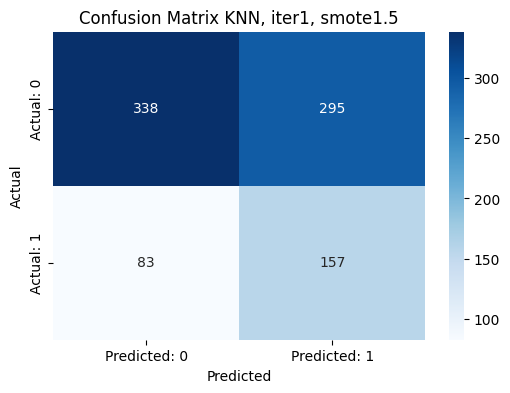

KNN iter1 with smote val1.5 Accuracy: 0.5670
              precision    recall  f1-score   support

           0       0.80      0.53      0.64       633
           1       0.35      0.65      0.45       240

    accuracy                           0.57       873
   macro avg       0.58      0.59      0.55       873
weighted avg       0.68      0.57      0.59       873

Saved KNN pipeline as: knn_iter1_smote1.5_pipeline.pkl

Training XGBoost on 1 with smote val 1.5...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[440 193]
 [ 89 151]]


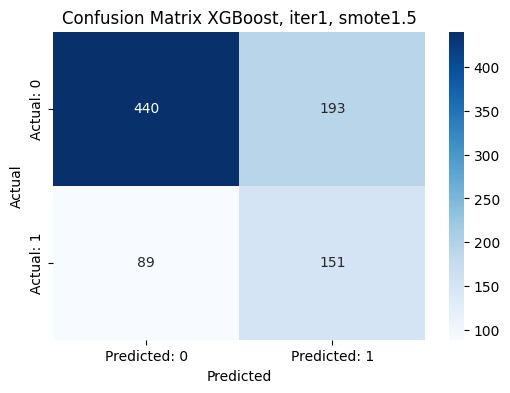

XGBoost iter1 with smote val1.5 Accuracy: 0.6770
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       633
           1       0.44      0.63      0.52       240

    accuracy                           0.68       873
   macro avg       0.64      0.66      0.64       873
weighted avg       0.72      0.68      0.69       873

Saved XGBoost pipeline as: xgboost_iter1_smote1.5_pipeline.pkl


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

count = 1
results = []

oversampling_prob = [0.8, 1.1, 1.5]

for val in oversampling_prob:

  maj_label = y_train.value_counts().idxmax()
  maj_count = y_train.value_counts().max()
  min_label = [lab for lab in y_train.value_counts().index if lab != maj_label][0]

  desired_minority = int(maj_count * val)
  smote = SMOTE(sampling_strategy={min_label: desired_minority}, k_neighbors=7, random_state=42)

  for name, model in models.items():
      print(f"\nTraining {name} on {count} with smote val {val}...")

      pipeline = Pipeline(steps=[
          ('preprocess', preprocessor),
          ('smote', smote),
          ('model', model)
      ])

      param_grid = param_grids.get(name, {})

      # Setup GridSearchCV
      grid_search = GridSearchCV(
          pipeline,
          param_grid=param_grid,
          cv=5,
          scoring='f1',
          n_jobs=-1,  # use all CPU cores
          verbose=1
      )

      # Fit grid search
      grid_search.fit(X_train, y_train)
      best_model = grid_search.best_estimator_

      y_pred = best_model.predict(X_test)

      # Calculate metrics
      acc = accuracy_score(y_test, y_pred)
      prec = precision_score(y_test, y_pred, average='weighted')
      rec = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test, y_pred, average='weighted')

      # confusion matrix
      cm = confusion_matrix(y_test, y_pred)
      print(cm)

      plt.figure(figsize=(6,4))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=['Predicted: 0', 'Predicted: 1'],
                  yticklabels=['Actual: 0', 'Actual: 1'])
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.title(f'Confusion Matrix {name}, iter{count}, smote{val}')
      plt.show()

      # Append metrics to list
      results.append({
          'Iteration': count,
          'Smote val': val,
          'Model': name,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F1-Score': f1
      })

      print(f"{name} iter{count} with smote val{val} Accuracy: {acc:.4f}")
      print(classification_report(y_test, y_pred))

      # # Save full training pipeline
      filename = f"{name.replace(' ', '_').lower()}_iter{count}_smote{val}_pipeline.pkl"
      joblib.dump(pipeline, filename)
      print(f"Saved {name} pipeline as: {filename}")

      count =+ 1


In [69]:
results_df = pd.DataFrame(results)


In [75]:
results_df.head(20)

,Iteration,Smote val,Model,Accuracy,Precision,Recall,F1-Score
0,1,0.8,Random Forest,0.683849,0.711188,0.683849,0.694029
1,1,0.8,Logistic Regression,0.651775,0.737382,0.651775,0.670333
2,1,0.8,Decision Tree,0.650630,0.674530,0.650630,0.660368
3,1,0.8,Gradient Boosting,0.713631,0.709249,0.713631,0.711304
4,1,0.8,SVM,0.639175,0.731825,0.639175,0.658487
5,1,0.8,KNN,0.643757,0.683962,0.643757,0.657944
6,1,0.8,XGBoost,0.729668,0.688664,0.729668,0.678341
7,1,1.1,Random Forest,0.690722,0.714150,0.690722,0.699721
8,1,1.1,Logistic Regression,0.646048,0.728765,0.646048,0.664836
9,1,1.1,Decision Tree,0.686140,0.704517,0.686140,0.693667


In [71]:
type(results_df)

pandas.core.frame.DataFrame

In [81]:
filtered = results_df[
    (results_df['Accuracy'] >= 0.68) &
    (results_df['Precision'] >= 0.68) &
    (results_df['Recall'] >= 0.68)
]

In [82]:
filtered

,Iteration,Smote val,Model,Accuracy,Precision,Recall,F1-Score
0,1,0.8,Random Forest,0.683849,0.711188,0.683849,0.694029
3,1,0.8,Gradient Boosting,0.713631,0.709249,0.713631,0.711304
6,1,0.8,XGBoost,0.729668,0.688664,0.729668,0.678341
7,1,1.1,Random Forest,0.690722,0.714150,0.690722,0.699721
9,1,1.1,Decision Tree,0.686140,0.704517,0.686140,0.693667
13,1,1.1,XGBoost,0.709049,0.712086,0.709049,0.710509
14,1,1.5,Random Forest,0.695304,0.709082,0.695304,0.701177
16,1,1.5,Decision Tree,0.694158,0.699348,0.694158,0.696604


In [91]:
from sklearn.ensemble import VotingClassifier
import os

model_list = ['random_forest_iter1_smote1.1_pipeline.pkl',
 'xgboost_iter1_smote1.1_pipeline.pkl',
 "gradient_boosting_iter1_smote0.8_pipeline.pkl",
 "decision_tree_iter1_smote1.5_pipeline.pkl"]

pipelines = [joblib.load(model) for model in model_list]

# Folder where you want to save the cleaned models
save_dir = "./clean_models"

# Create directory if it doesn’t exist
os.makedirs(save_dir, exist_ok=True)

clean_pipelines = []
for i, pipe in enumerate(pipelines, start=1):
    # Remove the 'smote' step
    steps_without_smote = [s for s in pipe.steps if s[0] != 'smote']

    # Recreate pipeline without SMOTE
    clean_pipe = Pipeline(steps_without_smote)
    clean_pipelines.append(clean_pipe)

    # Numbered filename
    filename = f"clean_pipeline_{i}.pkl"
    save_path = os.path.join(save_dir, filename)

    # Save cleaned pipeline
    joblib.dump(clean_pipe, save_path)
    print(f"✅ Saved cleaned pipeline: {save_path}")



✅ Saved cleaned pipeline: ./clean_models/clean_pipeline_1.pkl
✅ Saved cleaned pipeline: ./clean_models/clean_pipeline_2.pkl
✅ Saved cleaned pipeline: ./clean_models/clean_pipeline_3.pkl
✅ Saved cleaned pipeline: ./clean_models/clean_pipeline_4.pkl


In [92]:
import shutil

zip_filename = 'clean_models_backup'

shutil.make_archive(zip_filename, 'zip', save_dir)

print(f"Zipped all models into {zip_filename}.zip")

Zipped all models into clean_models_backup.zip


In [ ]:
# Example: new sample
new_data = pd.DataFrame([{
    'Age': '45-49',
    'Education': 'Secondary',
    'Family_History': 'Yes',
    'Parity': '3-4',
    'Age_at_Menarche': '12-13',
    'Age_at_Menopause': '45-49',
    'Body_Size': 'Medium'
}])


In [113]:
estimators = []
for i, pipe in enumerate(clean_pipelines):
    model = pipe.named_steps['model']
    estimators.append((f"model_{i+1}", model))


preprocess = pipelines[0].named_steps['preprocess']

from sklearn.pipeline import Pipeline

ensemble_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('voting', VotingClassifier(estimators=estimators, voting='soft', weights=[1, 2, 3, 1],))
])

# Train your ensemble
ensemble_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = ensemble_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7399770904925544

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84       633
           1       0.56      0.27      0.36       240

    accuracy                           0.74       873
   macro avg       0.66      0.59      0.60       873
weighted avg       0.71      0.74      0.71       873



In [114]:
joblib.dump(ensemble_pipeline, "weighted_voting_pipeline.pkl")

['weighted_voting_pipeline.pkl']

Test

In [115]:
voting_pipeline = joblib.load("weighted_voting_pipeline.pkl")

new_data = pd.DataFrame([{
    'Age': '40-49',
    'Education': 'Tertiary',
    'Family_History': 'Yes',
    'Parity': '2-3',
    'Age_at_Menarche': '12-13',
    'Age_at_Menopause': '50-55',
    'Body_Size': 'Normal'
}])

# Get predicted class
y_pred = voting_pipeline.predict(new_data)

# Get predicted probabilities for each class
y_proba = voting_pipeline.predict_proba(new_data)


In [116]:
print("🎯 Predicted Class:", y_pred[0])
print("🔢 Probabilities:")
print(f"  Class 0 (No Cancer): {y_proba[0][0]:.3f}")
print(f"  Class 1 (Cancer): {y_proba[0][1]:.3f}")


🎯 Predicted Class: 1
🔢 Probabilities:
  Class 0 (No Cancer): 0.454
  Class 1 (Cancer): 0.546
